In [62]:
library(glmnet)
library(dplyr)
library(tidyverse)
library(caret)

In [61]:
if (!require("sentimentr")) install.packages("sentimentr")
if (!require("wordcloud")) install.packages("wordcloud")

Loading required package: sentimentr

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘sentimentr’”
Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Warning message:
“unable to access index for repository https://mirror.rcg.sfu.ca/mirror/CRAN/src/contrib:
  cannot open URL 'https://mirror.rcg.sfu.ca/mirror/CRAN/src/contrib/PACKAGES'”
Warning message:
“package ‘sentimentr’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


**<h3>Best so far</h3>**

In [63]:
train_clean <- read.csv("train.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)) %>%
    select(-X, -id, -name, -neighborhood_overview, -host_id, -host_name, 
           -neighbourhood, -latitude, -longitude, host_response_time, host_response_rate, host_acceptance_rate, 
           host_is_superhost, host_listings_count, host_total_listings_count, -bathrooms, -bedrooms, -amenities,
          minimum_nights, maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, 
          review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, 
           review_scores_communication, review_scores_location, review_scores_value, number_of_reviews, 
           number_of_reviews_ltm, calculated_host_listings_count, reviews_per_month, neighbourhood_cleansed,
           property_type, room_type) %>%
    mutate(property_type = if_else(property_type %in% c("Camper/RV", "Entire home", 
                                                        "Entire villa", "Private room in bungalow", "Private room in condo",
                                                        "Room in hotel"),
                                  property_type,
                                  "Other"),
          neighbourhood_cleansed = if_else(neighbourhood_cleansed %in% c("Downtown Eastside", "Dunbar Southlands",
                                                                         "Grandview-Woodland", "Killarney", "Kitsilano", 
                                                                         "Marpole", "Mount Pleasant", "Oakridge", 
                                                                         "West End", "West Point Grey"),
                                          neighbourhood_cleansed,
                                          "Other"),
          room_type = if_else(room_type %in% c("Private room", "Shared room"),
                             room_type,
                             "Other"))
dmy <- dummyVars(" ~ .", data = train_clean)
train_clean <- data.frame(predict(dmy, newdata = train_clean))

test_clean <- read.csv("test.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)) %>%
    select(-id, -name, -neighborhood_overview, -host_id, -host_name, 
           -neighbourhood, -latitude, -longitude, host_response_time, host_response_rate, host_acceptance_rate, 
           host_is_superhost, host_listings_count, host_total_listings_count, -bathrooms, -bedrooms, -amenities,
          minimum_nights, maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, 
          review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, 
           review_scores_communication, review_scores_location, review_scores_value, number_of_reviews, 
           number_of_reviews_ltm, calculated_host_listings_count, reviews_per_month, neighbourhood_cleansed,
           property_type, room_type) %>%
    mutate(property_type = if_else(property_type %in% c("Camper/RV", "Entire home", 
                                                        "Entire villa", "Private room in bungalow", "Private room in condo",
                                                        "Room in hotel"),
                                  property_type,
                                  "Other"),
          neighbourhood_cleansed = if_else(neighbourhood_cleansed %in% c("Downtown Eastside", "Dunbar Southlands",
                                                                         "Grandview-Woodland", "Killarney", "Kitsilano", 
                                                                         "Marpole", "Mount Pleasant", "Oakridge", 
                                                                         "West End", "West Point Grey"),
                                          neighbourhood_cleansed,
                                          "Other"),
          room_type = if_else(room_type %in% c("Private room", "Shared room"),
                             room_type,
                             "Other"))
dmy <- dummyVars(" ~ .", data = test_clean)
test_clean <- data.frame(predict(dmy, newdata = test_clean))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”


[1] 5.777081

58 x 1 sparse Matrix of class "dgCMatrix"
                                                    s0
(Intercept)                              -1.242773e+03
host_response_time                        2.107106e+01
host_response_timea.few.days.or.more     -8.443499e+01
host_response_timewithin.a.day            .           
host_response_timewithin.a.few.hours      2.093378e+01
host_response_timewithin.an.hour         -1.136247e+00
host_response_rate                        3.718878e-01
host_acceptance_rate                      2.538902e-01
host_is_superhost                         .           
host_is_superhostf                        .           
host_is_superhostt                        .           
host_listings_count                       .           
host_total_listings_count                 3.151315e-02
neighbourhood_cleansedDowntown.Eastside   6.577431e+01
neighbourhood_cleansedDunbar.Southlands  -1.280339e+02
neighbourhood_cleansedGrandview.Woodland  1.424805e+02
neighbourhood_cleansedK

[1] 0.3013145

[1] 6658037739

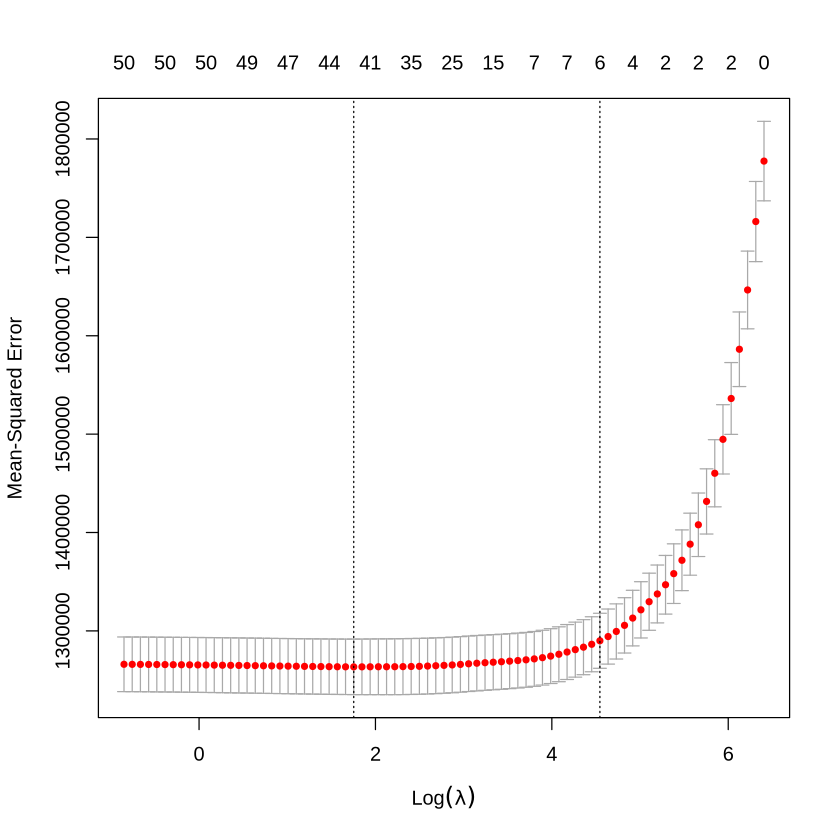

In [64]:
y_clean <- train_clean$monthly_revenue
x_clean <- makeX(train_clean %>% select(-monthly_revenue),
          na.impute = TRUE)

cv_model_clean <- cv.glmnet(x_clean, y_clean, alpha = 1)

best_lambda_clean <- cv_model_clean$lambda.min
best_lambda_clean

plot(cv_model_clean) 

best_model_clean <- glmnet(x_clean, y_clean, alpha = 1, lambda = best_lambda_clean)
coef(best_model_clean)

pred_y_clean <- predict(best_model_clean, s = best_lambda_clean, newx = x_clean)

sst_clean <- sum((y_clean - mean(y_clean))^2)
sse_clean <- sum((pred_y_clean - y_clean)^2)

rsq_clean <- 1 - sse_clean/sst_clean
rsq_clean
sse_clean 

In [65]:
x_test_clean <- makeX(test_clean,
          na.impute = TRUE)

t_test_clean <- predict(best_model_clean, s = best_lambda_clean, newx = x_test_clean)

In [23]:
latest <- data.frame(read.csv("test.csv", colClasses = c("id" = "character"))$id, t_test_clean)
colnames(latest) <- c("id", "predictions")
head(latest)

write.csv(latest, "latest_clean.csv", row.names = FALSE)

,id,predictions
,<chr>,<dbl>
1,4465400,3787.466
2,608629349064811166,1370.057
3,981894508939312892,1799.171
4,52014961,1719.834
5,836285112356489303,1262.120
6,729730483477613494,1846.086


**<h3>Plots</h3>**

In [42]:
plot_data <- select_if(read.csv("train.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)), is.numeric)
names(plot_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”


[1] "X"                              "id"                            
 [3] "host_id"                        "host_response_rate"            
 [5] "host_acceptance_rate"           "host_listings_count"           
 [7] "host_total_listings_count"      "latitude"                      
 [9] "longitude"                      "accommodates"                  
[11] "beds"                           "price"                         
[13] "minimum_nights"                 "maximum_nights"                
[15] "minimum_nights_avg_ntm"         "maximum_nights_avg_ntm"        
[17] "availability_30"                "availability_60"               
[19] "availability_90"                "availability_365"              
[21] "number_of_reviews"              "number_of_reviews_ltm"         
[23] "review_scores_rating"           "review_scores_accuracy"        
[25] "review_scores_cleanliness"      "review_scores_checkin"         
[27] "review_scores_communication"    "review_scores_location"        
[29] "review_scores_value"            "calculated_host_listings_count"
[31] "reviews_per_month"              "monthly_revenue"

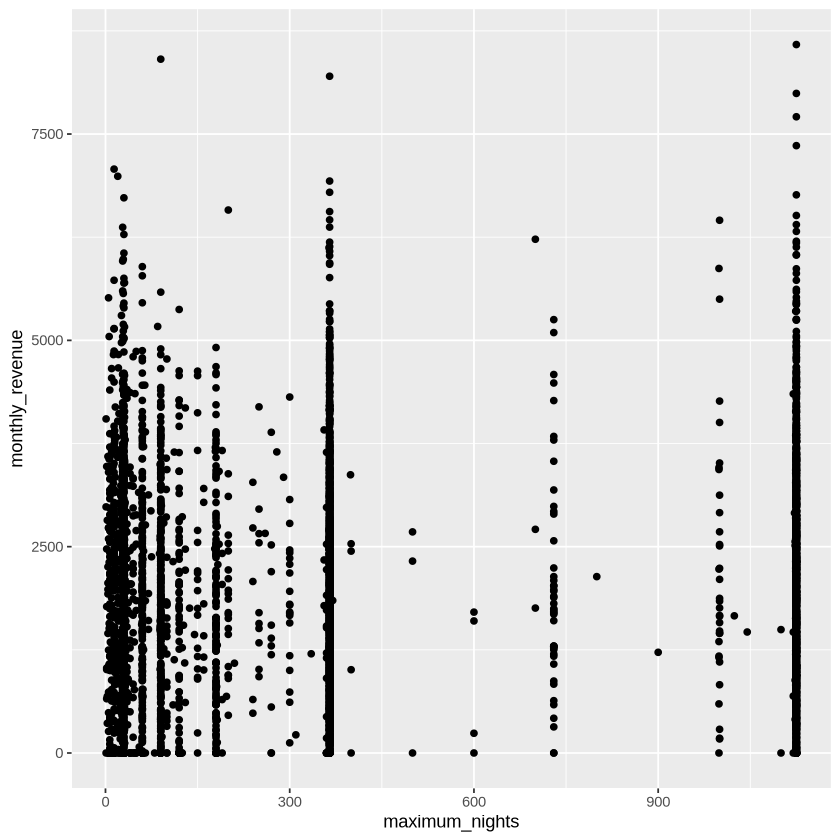

In [44]:
ggplot(data = plot_data, mapping = aes(x = maximum_nights, y = monthly_revenue)) +
    geom_point()

**<h3>Separate for each accomodates</h3>**

In [236]:
train_clean_30 <- read.csv("train.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)) %>%
    select(-X, -id, -name, -neighborhood_overview, -host_id, -host_name, 
           -neighbourhood, -latitude, -longitude, -host_response_time, -host_response_rate, -host_acceptance_rate, 
           -host_is_superhost, -host_listings_count, -host_total_listings_count, -bathrooms, -bedrooms, -amenities,
          -minimum_nights, -maximum_nights, -minimum_nights_avg_ntm, -maximum_nights_avg_ntm, 
          -review_scores_rating, -review_scores_accuracy, -review_scores_cleanliness, -review_scores_checkin, 
           -review_scores_communication, -review_scores_location, -review_scores_value, -number_of_reviews, 
           -number_of_reviews_ltm, -calculated_host_listings_count, -reviews_per_month, availability_30, -availability_60,
           -availability_90, -availability_365, neighbourhood_cleansed, property_type, room_type) %>%
    mutate(property_type = if_else(property_type %in% c("Camper/RV", "Entire home", 
                                                        "Entire villa", "Private room in bungalow", "Private room in condo",
                                                        "Room in hotel"),
                                  property_type,
                                  "Other"),
          neighbourhood_cleansed = if_else(neighbourhood_cleansed %in% c("Downtown Eastside", "Dunbar Southlands",
                                                                         "Grandview-Woodland", "Killarney", "Kitsilano", 
                                                                         "Marpole", "Mount Pleasant", "Oakridge", 
                                                                         "West End", "West Point Grey"),
                                          neighbourhood_cleansed,
                                          "Other"),
          room_type = if_else(room_type %in% c("Private room", "Shared room"),
                             room_type,
                             "Other"))
dmy <- dummyVars(" ~ .", data = train_clean_30)
train_clean_30 <- data.frame(predict(dmy, newdata = train_clean_30))

test_clean_30 <- read.csv("test.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)) %>%
    select(-id, -name, -neighborhood_overview, -host_id, -host_name, 
           -neighbourhood, -latitude, -longitude, -host_response_time, -host_response_rate, -host_acceptance_rate, 
           -host_is_superhost, -host_listings_count, -host_total_listings_count, -bathrooms, -bedrooms, -amenities,
          -minimum_nights, -maximum_nights, -minimum_nights_avg_ntm, -maximum_nights_avg_ntm, 
          -review_scores_rating, -review_scores_accuracy, -review_scores_cleanliness, -review_scores_checkin, 
           -review_scores_communication, -review_scores_location, -review_scores_value, -number_of_reviews, 
           -number_of_reviews_ltm, -calculated_host_listings_count, -reviews_per_month, availability_30, -availability_60,
           -availability_90, -availability_365, neighbourhood_cleansed, property_type, room_type) %>%
    mutate(property_type = if_else(property_type %in% c("Camper/RV", "Entire home", 
                                                        "Entire villa", "Private room in bungalow", "Private room in condo",
                                                        "Room in hotel"),
                                  property_type,
                                  "Other"),
          neighbourhood_cleansed = if_else(neighbourhood_cleansed %in% c("Downtown Eastside", "Dunbar Southlands",
                                                                         "Grandview-Woodland", "Killarney", "Kitsilano", 
                                                                         "Marpole", "Mount Pleasant", "Oakridge", 
                                                                         "West End", "West Point Grey"),
                                          neighbourhood_cleansed,
                                          "Other"),
          room_type = if_else(room_type %in% c("Private room", "Shared room"),
                             room_type,
                             "Other"))
dmy <- dummyVars(" ~ .", data = test_clean_30)
test_clean_30 <- data.frame(predict(dmy, newdata = test_clean_30))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”


[1] 2.2786

28 x 1 sparse Matrix of class "dgCMatrix"
                                                    s0
(Intercept)                               8.969415e+02
neighbourhood_cleansedDowntown.Eastside   1.016843e+02
neighbourhood_cleansedDunbar.Southlands  -1.597054e+02
neighbourhood_cleansedGrandview.Woodland  1.726413e+02
neighbourhood_cleansedKillarney           1.755403e+02
neighbourhood_cleansedKitsilano           4.231332e+01
neighbourhood_cleansedMarpole            -9.330613e+01
neighbourhood_cleansedMount.Pleasant     -7.618385e+01
neighbourhood_cleansedOakridge            1.498656e+02
neighbourhood_cleansedOther               .           
neighbourhood_cleansedWest.End           -4.471580e+01
neighbourhood_cleansedWest.Point.Grey    -7.630503e+01
property_typeCamper.RV                   -5.802772e+02
property_typeEntire.home                  9.422012e+02
property_typeEntire.villa                -6.074966e+02
property_typeOther                       -2.746363e+01
property_typePrivate.ro

[1] 0.2850334

[1] 6813185742

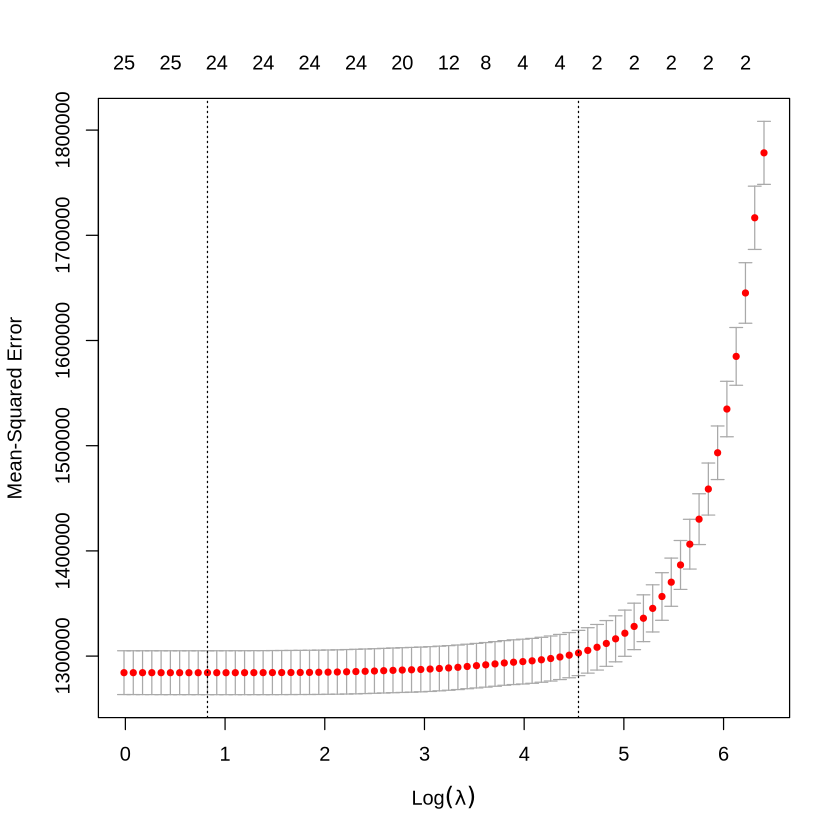

In [238]:
y_30 <- train_clean_30$monthly_revenue
x_30 <- makeX(train_clean_30 %>% select(-monthly_revenue),
          na.impute = TRUE)

cv_model_30 <- cv.glmnet(x_30, y_30, alpha = 1)

best_lambda_30 <- cv_model_30$lambda.min
best_lambda_30

plot(cv_model_30) 

best_model_30 <- glmnet(x_30, y_30, alpha = 1, lambda = best_lambda_30)
coef(best_model_30)

pred_y_30 <- predict(best_model_30, s = best_lambda_30, newx = x_30)

sst_30 <- sum((y_30 - mean(y_30))^2)
sse_30 <- sum((pred_y_30 - y_30)^2)

rsq_30 <- 1 - sse_30/sst_30
rsq_30
sse_30 

In [245]:
train_clean_60 <- read.csv("train.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)) %>%
    select(-X, -id, -name, -neighborhood_overview, -host_id, -host_name, 
           -neighbourhood, -latitude, -longitude, -host_response_time, -host_response_rate, -host_acceptance_rate, 
           -host_is_superhost, -host_listings_count, -host_total_listings_count, -bathrooms, -bedrooms, -amenities,
          -minimum_nights, -maximum_nights, -minimum_nights_avg_ntm, -maximum_nights_avg_ntm, 
          -review_scores_rating, -review_scores_accuracy, -review_scores_cleanliness, -review_scores_checkin, 
           -review_scores_communication, -review_scores_location, -review_scores_value, -number_of_reviews, 
           -number_of_reviews_ltm, -calculated_host_listings_count, -reviews_per_month, -availability_30, availability_60,
           -availability_90, -availability_365, neighbourhood_cleansed, property_type, room_type) %>%
    mutate(property_type = if_else(property_type %in% c("Camper/RV", "Entire home", 
                                                        "Entire villa", "Private room in bungalow", "Private room in condo",
                                                        "Room in hotel"),
                                  property_type,
                                  "Other"),
          neighbourhood_cleansed = if_else(neighbourhood_cleansed %in% c("Downtown Eastside", "Dunbar Southlands",
                                                                         "Grandview-Woodland", "Killarney", "Kitsilano", 
                                                                         "Marpole", "Mount Pleasant", "Oakridge", 
                                                                         "West End", "West Point Grey"),
                                          neighbourhood_cleansed,
                                          "Other"),
          room_type = if_else(room_type %in% c("Private room", "Shared room"),
                             room_type,
                             "Other"))
dmy <- dummyVars(" ~ .", data = train_clean_60)
train_clean_60 <- data.frame(predict(dmy, newdata = train_clean_60))

test_clean_60 <- read.csv("test.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)) %>%
    select(-id, -name, -neighborhood_overview, -host_id, -host_name, 
           -neighbourhood, -latitude, -longitude, -host_response_time, -host_response_rate, -host_acceptance_rate, 
           -host_is_superhost, -host_listings_count, -host_total_listings_count, -bathrooms, -bedrooms, -amenities,
          -minimum_nights, -maximum_nights, -minimum_nights_avg_ntm, -maximum_nights_avg_ntm, 
          -review_scores_rating, -review_scores_accuracy, -review_scores_cleanliness, -review_scores_checkin, 
           -review_scores_communication, -review_scores_location, -review_scores_value, -number_of_reviews, 
           -number_of_reviews_ltm, -calculated_host_listings_count, -reviews_per_month, -availability_30, availability_60,
           -availability_90, -availability_365, neighbourhood_cleansed, property_type, room_type) %>%
    mutate(property_type = if_else(property_type %in% c("Camper/RV", "Entire home", 
                                                        "Entire villa", "Private room in bungalow", "Private room in condo",
                                                        "Room in hotel"),
                                  property_type,
                                  "Other"),
          neighbourhood_cleansed = if_else(neighbourhood_cleansed %in% c("Downtown Eastside", "Dunbar Southlands",
                                                                         "Grandview-Woodland", "Killarney", "Kitsilano", 
                                                                         "Marpole", "Mount Pleasant", "Oakridge", 
                                                                         "West End", "West Point Grey"),
                                          neighbourhood_cleansed,
                                          "Other"),
          room_type = if_else(room_type %in% c("Private room", "Shared room"),
                             room_type,
                             "Other"))
dmy <- dummyVars(" ~ .", data = test_clean_60)
test_clean_60 <- data.frame(predict(dmy, newdata = test_clean_60))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”


[1] 0.9863515

28 x 1 sparse Matrix of class "dgCMatrix"
                                                    s0
(Intercept)                               9.071684e+02
neighbourhood_cleansedDowntown.Eastside   1.098902e+02
neighbourhood_cleansedDunbar.Southlands  -1.695280e+02
neighbourhood_cleansedGrandview.Woodland  1.734340e+02
neighbourhood_cleansedKillarney           1.838420e+02
neighbourhood_cleansedKitsilano           4.616896e+01
neighbourhood_cleansedMarpole            -9.962467e+01
neighbourhood_cleansedMount.Pleasant     -8.116421e+01
neighbourhood_cleansedOakridge            1.547894e+02
neighbourhood_cleansedOther               .           
neighbourhood_cleansedWest.End           -4.770595e+01
neighbourhood_cleansedWest.Point.Grey    -8.704300e+01
property_typeCamper.RV                   -6.098507e+02
property_typeEntire.home                  9.460226e+02
property_typeEntire.villa                -6.265349e+02
property_typeOther                       -2.564487e+01
property_typePrivate.ro

[1] 0.2854805

[1] 6808925535

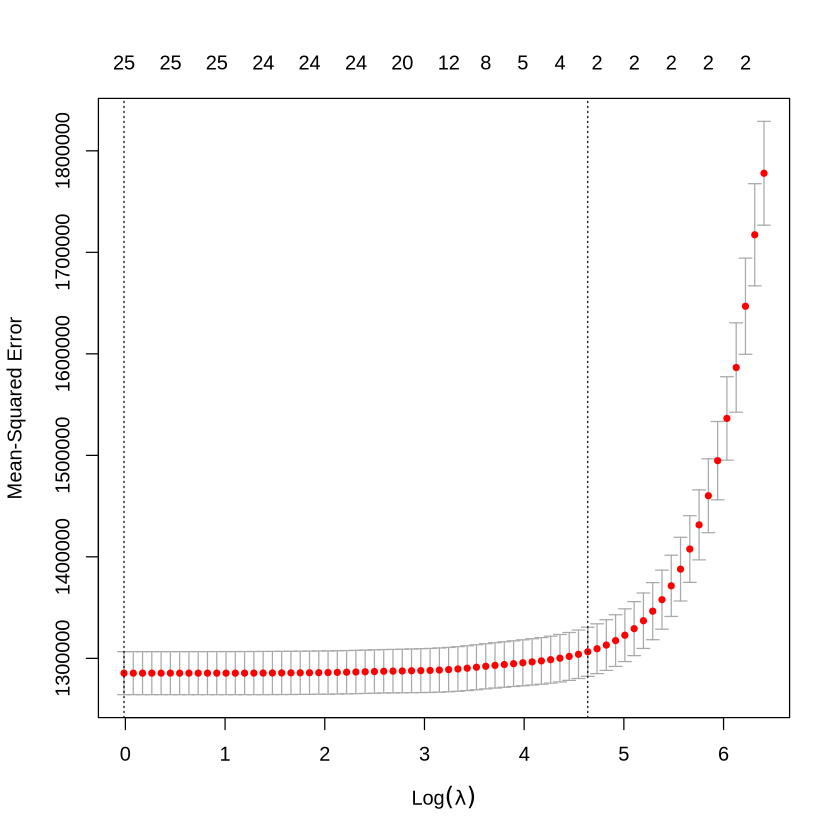

In [246]:
y_60 <- train_clean_60$monthly_revenue
x_60 <- makeX(train_clean_60 %>% select(-monthly_revenue),
          na.impute = TRUE)

cv_model_60 <- cv.glmnet(x_60, y_60, alpha = 1)

best_lambda_60 <- cv_model_60$lambda.min
best_lambda_60

plot(cv_model_60) 

best_model_60 <- glmnet(x_60, y_60, alpha = 1, lambda = best_lambda_60)
coef(best_model_60)

pred_y_60 <- predict(best_model_60, s = best_lambda_60, newx = x_60)

sst_60 <- sum((y_60 - mean(y_60))^2)
sse_60 <- sum((pred_y_60 - y_60)^2)

rsq_60 <- 1 - sse_60/sst_60
rsq_60
sse_60 

In [247]:
train_clean_90 <- read.csv("train.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)) %>%
    select(-X, -id, -name, -neighborhood_overview, -host_id, -host_name, 
           -neighbourhood, -latitude, -longitude, -host_response_time, -host_response_rate, -host_acceptance_rate, 
           -host_is_superhost, -host_listings_count, -host_total_listings_count, -bathrooms, -bedrooms, -amenities,
          -minimum_nights, -maximum_nights, -minimum_nights_avg_ntm, -maximum_nights_avg_ntm, 
          -review_scores_rating, -review_scores_accuracy, -review_scores_cleanliness, -review_scores_checkin, 
           -review_scores_communication, -review_scores_location, -review_scores_value, -number_of_reviews, 
           -number_of_reviews_ltm, -calculated_host_listings_count, -reviews_per_month, -availability_30, -availability_60,
           availability_90, -availability_365, neighbourhood_cleansed, property_type, room_type) %>%
    mutate(property_type = if_else(property_type %in% c("Camper/RV", "Entire home", 
                                                        "Entire villa", "Private room in bungalow", "Private room in condo",
                                                        "Room in hotel"),
                                  property_type,
                                  "Other"),
          neighbourhood_cleansed = if_else(neighbourhood_cleansed %in% c("Downtown Eastside", "Dunbar Southlands",
                                                                         "Grandview-Woodland", "Killarney", "Kitsilano", 
                                                                         "Marpole", "Mount Pleasant", "Oakridge", 
                                                                         "West End", "West Point Grey"),
                                          neighbourhood_cleansed,
                                          "Other"),
          room_type = if_else(room_type %in% c("Private room", "Shared room"),
                             room_type,
                             "Other"))
dmy <- dummyVars(" ~ .", data = train_clean_90)
train_clean_90 <- data.frame(predict(dmy, newdata = train_clean_90))

test_clean_90 <- read.csv("test.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)) %>%
    select(-id, -name, -neighborhood_overview, -host_id, -host_name, 
           -neighbourhood, -latitude, -longitude, -host_response_time, -host_response_rate, -host_acceptance_rate, 
           -host_is_superhost, -host_listings_count, -host_total_listings_count, -bathrooms, -bedrooms, -amenities,
          -minimum_nights, -maximum_nights, -minimum_nights_avg_ntm, -maximum_nights_avg_ntm, 
          -review_scores_rating, -review_scores_accuracy, -review_scores_cleanliness, -review_scores_checkin, 
           -review_scores_communication, -review_scores_location, -review_scores_value, -number_of_reviews, 
           -number_of_reviews_ltm, -calculated_host_listings_count, -reviews_per_month, -availability_30, -availability_60,
           availability_90, -availability_365, neighbourhood_cleansed, property_type, room_type) %>%
    mutate(property_type = if_else(property_type %in% c("Camper/RV", "Entire home", 
                                                        "Entire villa", "Private room in bungalow", "Private room in condo",
                                                        "Room in hotel"),
                                  property_type,
                                  "Other"),
          neighbourhood_cleansed = if_else(neighbourhood_cleansed %in% c("Downtown Eastside", "Dunbar Southlands",
                                                                         "Grandview-Woodland", "Killarney", "Kitsilano", 
                                                                         "Marpole", "Mount Pleasant", "Oakridge", 
                                                                         "West End", "West Point Grey"),
                                          neighbourhood_cleansed,
                                          "Other"),
          room_type = if_else(room_type %in% c("Private room", "Shared room"),
                             room_type,
                             "Other"))
dmy <- dummyVars(" ~ .", data = test_clean_90)
test_clean_90 <- data.frame(predict(dmy, newdata = test_clean_90))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”


[1] 5.263861

28 x 1 sparse Matrix of class "dgCMatrix"
                                                    s0
(Intercept)                               8.764256e+02
neighbourhood_cleansedDowntown.Eastside   8.438346e+01
neighbourhood_cleansedDunbar.Southlands  -1.404226e+02
neighbourhood_cleansedGrandview.Woodland  1.553261e+02
neighbourhood_cleansedKillarney           1.476372e+02
neighbourhood_cleansedKitsilano           2.815613e+01
neighbourhood_cleansedMarpole            -6.671860e+01
neighbourhood_cleansedMount.Pleasant     -6.717133e+01
neighbourhood_cleansedOakridge            1.308042e+02
neighbourhood_cleansedOther               .           
neighbourhood_cleansedWest.End           -3.678777e+01
neighbourhood_cleansedWest.Point.Grey    -5.387655e+01
property_typeCamper.RV                   -4.995756e+02
property_typeEntire.home                  9.235937e+02
property_typeEntire.villa                -5.551556e+02
property_typeOther                       -4.151844e+01
property_typePrivate.ro

[1] 0.2854015

[1] 6809678133

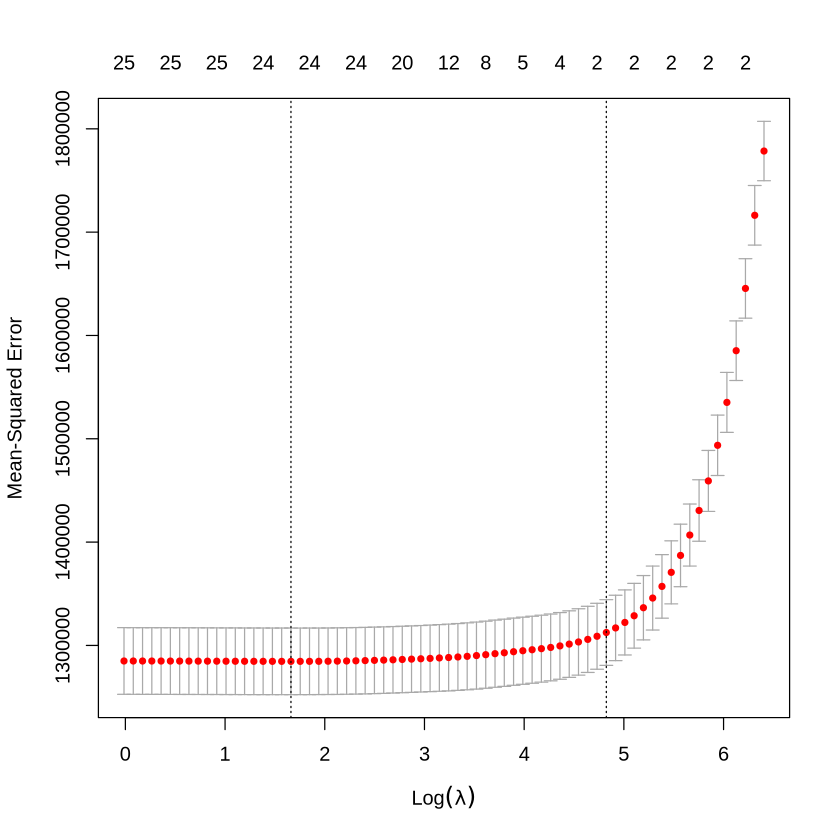

In [248]:
y_90 <- train_clean_90$monthly_revenue
x_90 <- makeX(train_clean_90 %>% select(-monthly_revenue),
          na.impute = TRUE)

cv_model_90 <- cv.glmnet(x_90, y_90, alpha = 1)

best_lambda_90 <- cv_model_90$lambda.min
best_lambda_90

plot(cv_model_90) 

best_model_90 <- glmnet(x_90, y_90, alpha = 1, lambda = best_lambda_90)
coef(best_model_90)

pred_y_90 <- predict(best_model_90, s = best_lambda_90, newx = x_90)

sst_90 <- sum((y_90 - mean(y_90))^2)
sse_90 <- sum((pred_y_90 - y_90)^2)

rsq_90 <- 1 - sse_90/sst_90
rsq_90
sse_90 

In [249]:
train_clean_365 <- read.csv("train.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)) %>%
    select(-X, -id, -name, -neighborhood_overview, -host_id, -host_name, 
           -neighbourhood, -latitude, -longitude, -host_response_time, -host_response_rate, -host_acceptance_rate, 
           -host_is_superhost, -host_listings_count, -host_total_listings_count, -bathrooms, -bedrooms, -amenities,
          -minimum_nights, -maximum_nights, -minimum_nights_avg_ntm, -maximum_nights_avg_ntm, 
          -review_scores_rating, -review_scores_accuracy, -review_scores_cleanliness, -review_scores_checkin, 
           -review_scores_communication, -review_scores_location, -review_scores_value, -number_of_reviews, 
           -number_of_reviews_ltm, -calculated_host_listings_count, -reviews_per_month, -availability_30, -availability_60,
           -availability_90, availability_365, neighbourhood_cleansed, property_type, room_type) %>%
    mutate(property_type = if_else(property_type %in% c("Camper/RV", "Entire home", 
                                                        "Entire villa", "Private room in bungalow", "Private room in condo",
                                                        "Room in hotel"),
                                  property_type,
                                  "Other"),
          neighbourhood_cleansed = if_else(neighbourhood_cleansed %in% c("Downtown Eastside", "Dunbar Southlands",
                                                                         "Grandview-Woodland", "Killarney", "Kitsilano", 
                                                                         "Marpole", "Mount Pleasant", "Oakridge", 
                                                                         "West End", "West Point Grey"),
                                          neighbourhood_cleansed,
                                          "Other"),
          room_type = if_else(room_type %in% c("Private room", "Shared room"),
                             room_type,
                             "Other"))
dmy <- dummyVars(" ~ .", data = train_clean_365)
train_clean_365 <- data.frame(predict(dmy, newdata = train_clean_365))

test_clean_365 <- read.csv("test.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1),
          price = as.numeric(price),
          host_response_rate = as.numeric(host_response_rate),
          host_acceptance_rate = as.numeric(host_acceptance_rate)) %>%
    select(-id, -name, -neighborhood_overview, -host_id, -host_name, 
           -neighbourhood, -latitude, -longitude, -host_response_time, -host_response_rate, -host_acceptance_rate, 
           -host_is_superhost, -host_listings_count, -host_total_listings_count, -bathrooms, -bedrooms, -amenities,
          -minimum_nights, -maximum_nights, -minimum_nights_avg_ntm, -maximum_nights_avg_ntm, 
          -review_scores_rating, -review_scores_accuracy, -review_scores_cleanliness, -review_scores_checkin, 
           -review_scores_communication, -review_scores_location, -review_scores_value, -number_of_reviews, 
           -number_of_reviews_ltm, -calculated_host_listings_count, -reviews_per_month, -availability_30, -availability_60,
           -availability_90, availability_365, neighbourhood_cleansed, property_type, room_type) %>%
    mutate(property_type = if_else(property_type %in% c("Camper/RV", "Entire home", 
                                                        "Entire villa", "Private room in bungalow", "Private room in condo",
                                                        "Room in hotel"),
                                  property_type,
                                  "Other"),
          neighbourhood_cleansed = if_else(neighbourhood_cleansed %in% c("Downtown Eastside", "Dunbar Southlands",
                                                                         "Grandview-Woodland", "Killarney", "Kitsilano", 
                                                                         "Marpole", "Mount Pleasant", "Oakridge", 
                                                                         "West End", "West Point Grey"),
                                          neighbourhood_cleansed,
                                          "Other"),
          room_type = if_else(room_type %in% c("Private room", "Shared room"),
                             room_type,
                             "Other"))
dmy <- dummyVars(" ~ .", data = test_clean_365)
test_clean_365 <- data.frame(predict(dmy, newdata = test_clean_365))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”


[1] 4.796234

28 x 1 sparse Matrix of class "dgCMatrix"
                                                    s0
(Intercept)                               8.835434e+02
neighbourhood_cleansedDowntown.Eastside   7.804532e+01
neighbourhood_cleansedDunbar.Southlands  -1.393147e+02
neighbourhood_cleansedGrandview.Woodland  1.556802e+02
neighbourhood_cleansedKillarney           1.547378e+02
neighbourhood_cleansedKitsilano           4.107885e+01
neighbourhood_cleansedMarpole            -7.092866e+01
neighbourhood_cleansedMount.Pleasant     -6.004597e+01
neighbourhood_cleansedOakridge            1.249772e+02
neighbourhood_cleansedOther               .           
neighbourhood_cleansedWest.End           -4.001370e+01
neighbourhood_cleansedWest.Point.Grey    -6.069935e+01
property_typeCamper.RV                   -4.669270e+02
property_typeEntire.home                  9.209534e+02
property_typeEntire.villa                -5.651859e+02
property_typeOther                       -4.033385e+01
property_typePrivate.ro

[1] 0.2864394

[1] 6799787471

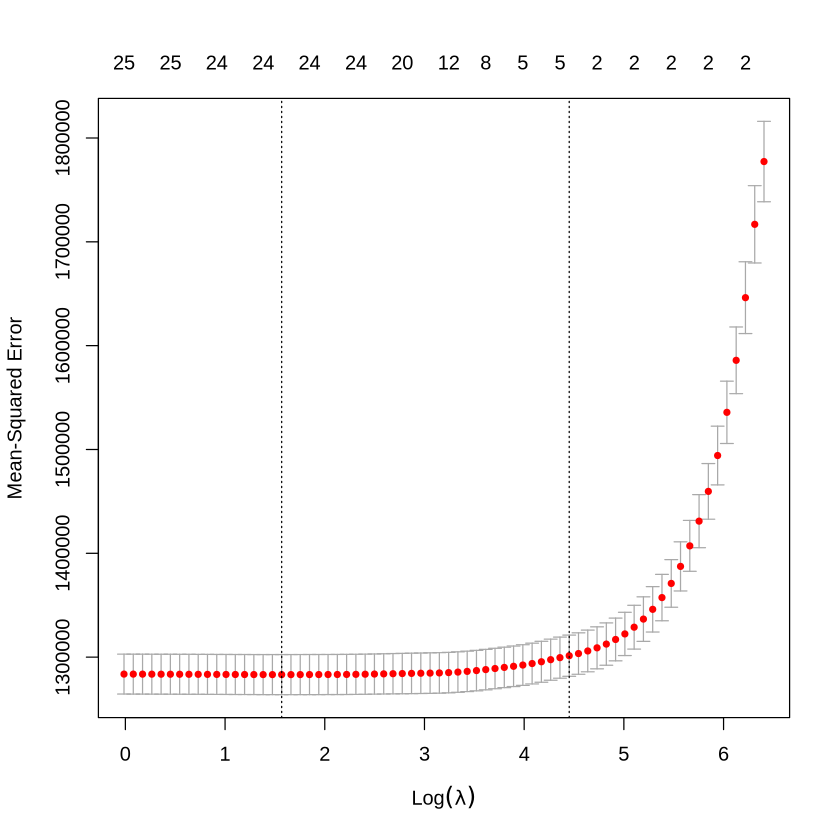

In [264]:
y_365 <- train_clean_365$monthly_revenue
x_365 <- makeX(train_clean_365 %>% select(-monthly_revenue),
          na.impute = TRUE)

cv_model_365 <- cv.glmnet(x_365, y_365, alpha = 1)

best_lambda_365 <- cv_model_365$lambda.min
best_lambda_365

plot(cv_model_365) 

best_model_365 <- glmnet(x_365, y_365, alpha = 1, lambda = best_lambda_365)
coef(best_model_365)

pred_y_365 <- predict(best_model_365, s = best_lambda_365, newx = x_365)

sst_365 <- sum((y_365 - mean(y_365))^2)
sse_365 <- sum((pred_y_365 - y_365)^2)

rsq_365 <- 1 - sse_365/sst_365
rsq_365
sse_365 

In [255]:
x_test_clean_30 <- makeX(test_clean %>%
                             select(-availability_60, -availability_90, -availability_365),
          na.impute = TRUE)

t_test_clean_30 <- predict(best_model_30, s = best_lambda_30, newx = x_test_clean_30)


In [ ]:
x_test_clean_60 <- makeX(test_clean %>%
                             select(-availability_30, -availability_90, -availability_365),
          na.impute = TRUE)

t_test_clean_60 <- predict(best_model_60, s = best_lambda_60, newx = x_test_clean_60)


In [256]:
x_test_clean_90 <- makeX(test_clean %>%
                             select(-availability_30, -availability_60, -availability_365),
          na.impute = TRUE)

t_test_clean_90 <- predict(best_model_90, s = best_lambda_90, newx = x_test_clean_90)


In [257]:
x_test_clean_365 <- makeX(test_clean %>%
                             select(-availability_30, -availability_60, -availability_90),
          na.impute = TRUE)

t_test_clean_365 <- predict(best_model_365, s = best_lambda_365, newx = x_test_clean_365)


In [261]:
t_test_clean_30

,s1
1,3692.437
2,1354.556
3,1691.874
4,1760.340
5,1171.716
6,1804.399
7,1305.170
8,1277.003
9,3420.806
10,2089.192


In [ ]:
latest <- data.frame(read.csv("test.csv", colClasses = c("id" = "character"))$id, t_test_clean)
colnames(latest) <- c("id", "predictions")
head(latest)

write.csv(latest, "latest_clean.csv", row.names = FALSE)

**<h3>Second Best</h3>**

In [10]:
train_data <- read.csv("train.csv")
test_data <- read.csv("test.csv", colClasses = c("id" = "character"))

In [11]:
train_data <- train_data %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1)) %>%
    mutate(price = as.numeric(price),
           host_response_rate = as.numeric(host_response_rate),
           host_acceptance_rate = as.numeric(host_acceptance_rate))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”


In [12]:
y <- train_data$monthly_revenue
x <- makeX(train_data[ , c('accommodates','beds',
                           'minimum_nights','maximum_nights',
                           'maximum_nights_avg_ntm','availability_30','availability_60','availability_90',
                           'availability_365','number_of_reviews','number_of_reviews_ltm',
                           'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                           'review_scores_value','instant_bookable')],
          na.impute = TRUE)

[1] 6.340339

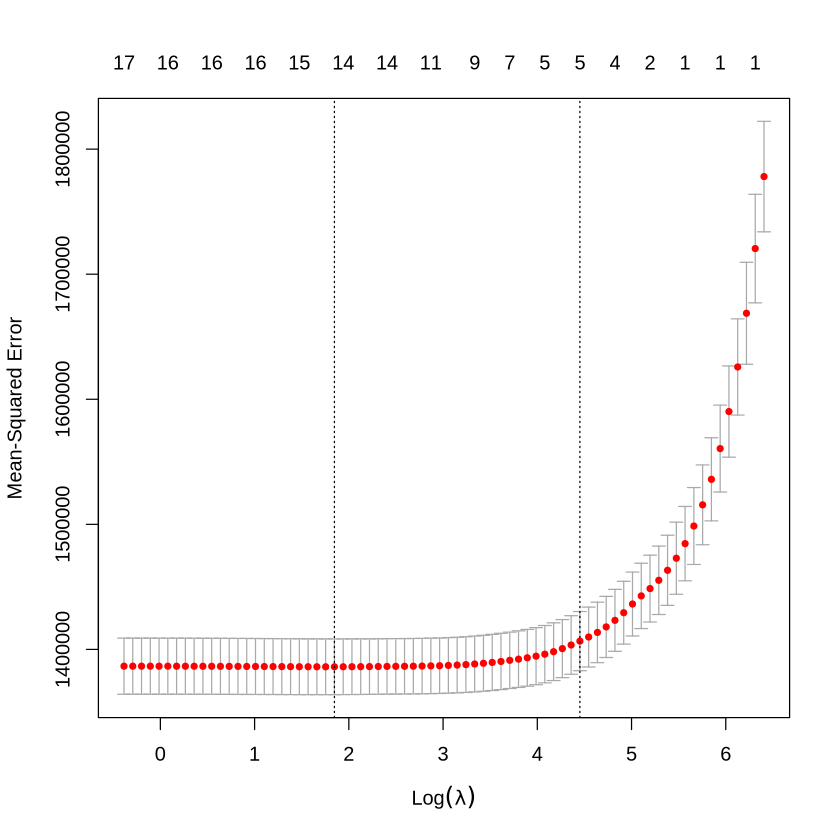

In [13]:
cv_model <- cv.glmnet(x, y, alpha = 1)

best_lambda <- cv_model$lambda.min
best_lambda

plot(cv_model) 

In [14]:
best_model <- glmnet(x, y, alpha = 1, lambda = best_lambda)
coef(best_model)

18 x 1 sparse Matrix of class "dgCMatrix"
                                     s0
(Intercept)               -1.253769e+03
accommodates               2.480781e+02
beds                       7.964737e+01
minimum_nights            -1.358631e+00
maximum_nights             1.890918e-02
maximum_nights_avg_ntm     4.194508e-02
availability_30            .           
availability_60            .           
availability_90           -6.798770e-02
availability_365          -5.321237e-01
number_of_reviews         -8.130561e-02
number_of_reviews_ltm     -4.161527e-01
review_scores_rating       2.397033e+02
review_scores_accuracy     .           
review_scores_cleanliness  3.458855e+01
review_scores_value        1.616754e+02
instant_bookablef          9.033117e+01
instant_bookablet         -3.309656e-11

In [15]:
pred_y <- predict(best_model, s = best_lambda, newx = x)

sst <- sum((y - mean(y))^2)
sse <- sum((pred_y - y)^2)

rsq <- 1 - sse/sst
rsq
sse 

[1] 0.2272458

[1] 7363865644

In [16]:
head(pred_y)
head(y)

,s1
1,1488.204
2,2269.475
3,2618.305
4,1485.060
5,2093.809
6,1299.889


[1] 2108 2730 2254 3187 3479    0

In [17]:
test_x <- makeX(test_data[ , c(
                           'accommodates','beds',
                           'minimum_nights','maximum_nights',
                           'maximum_nights_avg_ntm','availability_30','availability_60','availability_90',
                           'availability_365','number_of_reviews','number_of_reviews_ltm',
                           'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                           'review_scores_value','instant_bookable')],
          na.impute = TRUE)
test_pred_y <- predict(best_model, s = best_lambda, newx = test_x)

In [18]:
hello <- data.frame(test_data$id, test_pred_y)
colnames(hello) <- c("id", "predictions")
head(hello)

,id,predictions
,<chr>,<dbl>
1,4465400,3348.867
2,608629349064811166,1483.334
3,981894508939312892,2020.392
4,52014961,1959.779
5,836285112356489303,1339.873
6,729730483477613494,2100.476


In [19]:
write.csv(hello, "hello.csv", row.names = FALSE)

**<h3>Separate regressions (not that good)</h3>**

In [44]:
train <- read.csv("train.csv") %>%
    mutate(price = substr(price, 2, nchar(price)),
          host_response_rate = substr(host_response_rate, 1, nchar(host_response_rate) - 1),
          host_acceptance_rate = substr(host_acceptance_rate, 1, nchar(host_acceptance_rate) - 1)) %>%
    mutate(price = as.numeric(price),
           host_response_rate = as.numeric(host_response_rate),
           host_acceptance_rate = as.numeric(host_acceptance_rate))

test <- read.csv("test.csv", colClasses = c("id" = "character"))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”


In [45]:
unique(train$property_type)

[1] "Entire home"                        "Entire guest suite"                
 [3] "Entire condo"                       "Entire rental unit"                
 [5] "Entire townhouse"                   "Private room in guest suite"       
 [7] "Private room in home"               "Private room in townhouse"         
 [9] "Private room in condo"              "Private room in rental unit"       
[11] "Entire loft"                        "Entire serviced apartment"         
[13] "Shared room in rental unit"         "Private room in guesthouse"        
[15] "Private room in villa"              "Room in boutique hotel"            
[17] "Entire guesthouse"                  "Casa particular"                   
[19] "Shared room in home"                "Private room in tiny home"         
[21] "Private room in loft"               "Tiny home"                         
[23] "Entire timeshare"                   "Entire vacation home"              
[25] "Camper/RV"                          "Tower"                             
[27] "Entire cabin"                       "Room in aparthotel"                
[29] "Room in bed and breakfast"          "Private room in casa particular"   
[31] "Private room in bed and breakfast"  "Entire villa"                      
[33] "Entire bungalow"                    "Room in hotel"                     
[35] "Entire place"                       "Shared room in condo"              
[37] "Entire cottage"                     "Private room in bungalow"          
[39] "Private room in boat"               "Private room in camper/rv"         
[41] "Boat"                               "Shared room in villa"              
[43] "Private room in serviced apartment" "Private room in castle"            
[45] "Cave"                               "Shared room in loft"

**ENTIRE**

In [36]:
train_e <- train %>%
    filter(grepl("entire", tolower(property_type), fixed = TRUE))

In [37]:
unique(train_e$property_type)

[1] "Entire home"               "Entire guest suite"       
 [3] "Entire condo"              "Entire rental unit"       
 [5] "Entire townhouse"          "Entire loft"              
 [7] "Entire serviced apartment" "Entire guesthouse"        
 [9] "Entire timeshare"          "Entire vacation home"     
[11] "Entire cabin"              "Entire villa"             
[13] "Entire bungalow"           "Entire place"             
[15] "Entire cottage"

**PRIVATE**

In [38]:
train_p <- train %>%
    filter(grepl("private", tolower(property_type), fixed = TRUE))

In [39]:
unique(train_p$property_type)

[1] "Private room in guest suite"        "Private room in home"              
 [3] "Private room in townhouse"          "Private room in condo"             
 [5] "Private room in rental unit"        "Private room in guesthouse"        
 [7] "Private room in villa"              "Private room in tiny home"         
 [9] "Private room in loft"               "Private room in casa particular"   
[11] "Private room in bed and breakfast"  "Private room in bungalow"          
[13] "Private room in boat"               "Private room in camper/rv"         
[15] "Private room in serviced apartment" "Private room in castle"

**SHARED**

In [40]:
train_s <- train %>%
    filter(grepl("shared", tolower(property_type), fixed = TRUE))

In [41]:
unique(train_s$property_type)

[1] "Shared room in rental unit" "Shared room in home"       
[3] "Shared room in condo"       "Shared room in villa"      
[5] "Shared room in loft"

**OTHER**

In [1]:
train_o <- train %>%
    filter(!grepl("shared", tolower(property_type), fixed = TRUE) &
           !grepl("private", tolower(property_type), fixed = TRUE) &
           !grepl("entire", tolower(property_type), fixed = TRUE))
unique(train_o$property_type)

ERROR: Error in train %>% filter(!grepl("shared", tolower(property_type), fixed = TRUE) & : could not find function "%>%"
